# Trabalho Final - Análise de acidentes nas Rodovias do Brasil em 2019

Este projeto é a implementação de um modelo de Machine Learning utilizando Python 3 no Google Cloud (GCP). Os dados utilizados foram obtidos no site da Polícia Federal Rodoviária - PFR neste link: https://arquivos.prf.gov.br/arquivos/index.php/s/kRBUylqz6DyQznN. O dataset datatran2019.csv possui dados a respeito de todos os acidentes rodoviários em rodovias federais brasileiras no ano de 2019. Acidentes em rodovias estaduais ou municipais não estão neste dataset.


In [40]:
from IPython.display import HTML
import math
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [38]:
#funcoes

def convertToYesNo(data, columnName):
    #data = data.astype({columnName: object})
    data[columnName].replace(to_replace= {1:'Sim',0:'Não'}, inplace= True)

def convertColumnsToYesNo(data,columns):
    for item in columns:
        convertToYesNo(data,item)

def createPLot(data, columnName, labelCategory, topValues = 10, isShow = True):
    values_ocean = data[columnName].value_counts().head(topValues)
    values_ocean.plot(kind='bar', colormap = 'winter')

    plt.title('Variável categórica "' + labelCategory + '" Top ' + str(topValues) + '')
    plt.xlabel(labelCategory)
    plt.ylabel('Frequência')

    plt.show()

def createPLotBarh(data, columnName, labelCategory):
    countStatus = data[columnName].value_counts().sort_values()
    plt.title('Variável categórica "' + labelCategory + '"')    
    plt.ylabel('Frequência')
    countStatus.plot.barh()

    plt.show() 

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x


In [3]:
#Importação dos dados.
#low_memory: recebeu False como parâmetro para que os campos fossem lidos conforme consta no arquivo, de modo a evitar a tipagem de cada campo manualmente

dataSource = pd.read_csv('DataSource/acidentes2019_todas_causas_tipos_encode.csv', sep = ';')#, low_memory= False
dataSource.head()

,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,...,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
0,182210.0,402103.0,2019-01-01,terça-feira,01:30:00,SP,116.0,218,GUARULHOS,Sim,...,Masculino,0,1,0,0,"-23,46052014","-46,48772478",SR-SP,DEL6/1,UOP01/SP
1,182210.0,402106.0,2019-01-01,terça-feira,01:30:00,SP,116.0,218,GUARULHOS,Sim,...,Masculino,0,1,0,0,"-23,46052014","-46,48772478",SR-SP,DEL6/1,UOP01/SP
2,182210.0,402104.0,2019-01-01,terça-feira,01:30:00,SP,116.0,218,GUARULHOS,Sim,...,Feminino,0,1,0,0,"-23,46052014","-46,48772478",SR-SP,DEL6/1,UOP01/SP
3,182210.0,402102.0,2019-01-01,terça-feira,01:30:00,SP,116.0,218,GUARULHOS,Sim,...,Masculino,0,1,0,0,"-23,46052014","-46,48772478",SR-SP,DEL6/1,UOP01/SP
4,182211.0,402126.0,2019-01-01,terça-feira,01:30:00,PR,373.0,"177,3",PONTA GROSSA,Sim,...,Masculino,0,1,0,0,"-25,05533957","-50,22776753",SR-PR,DEL7/3,UOP01/PR


In [4]:
dataSource.tail()

,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,...,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop
331661,266434.0,593948.0,2019-06-03,segunda-feira,19:00:00,CE,222.0,"1,4",CAUCAIA,Sim,...,Masculino,0,0,1,0,"-3,736507","-38,65337",SR-CE,DEL16/1,UOP01/CE
331662,266434.0,593947.0,2019-06-03,segunda-feira,19:00:00,CE,222.0,"1,4",CAUCAIA,Sim,...,Masculino,1,0,0,0,"-3,736507","-38,65337",SR-CE,DEL16/1,UOP01/CE
331663,266573.0,594270.0,2019-07-13,sábado,19:35:00,PR,373.0,425,CANDOI,Sim,...,Masculino,0,0,1,0,"-25,71180139","-52,18373987",SR-PR,DEL7/3,UOP02/PR
331664,266573.0,594270.0,2019-07-13,sábado,19:35:00,PR,373.0,425,CANDOI,Sim,...,Masculino,0,0,1,0,"-25,71180139","-52,18373987",SR-PR,DEL7/3,UOP02/PR
331665,266627.0,594393.0,2019-10-22,terça-feira,20:20:00,BA,324.0,608,SIMOES FILHO,Sim,...,Masculino,0,1,0,0,"-12,78155812","-38,41655733",SR-BA,DEL10/1,UOP01/BA


### Parte 1: Análise e visualização de dados 

### Parte 1: Análise e visualização de dados - Dados não importantes
Vamos remover as colunas ['id', 'pesid', 'ordem_tipo_acidente','id_veiculo', 'uop'] pois se tratam de colunas de indentificação e não tem importancia para o modelo.


In [5]:
#memovendo colunas inuteis
removerColunas = ['id', 'pesid', 'ordem_tipo_acidente', 'id_veiculo', 'uop']
dataSource = dataSource.drop(removerColunas, axis=1)

### Parte 1: Análise e visualização de dados - Tipos de Dados
Encontramos tipos de dados inválidos, como 'id' e 'pesoid' que vamos ajustar porteriormente.


In [6]:
#analise de tipos de dados
dataSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331666 entries, 0 to 331665
Data columns (total 32 columns):
data_inversa              331666 non-null object
dia_semana                331666 non-null object
horario                   331666 non-null object
uf                        331666 non-null object
br                        331291 non-null float64
km                        331291 non-null object
municipio                 331666 non-null object
causa_principal           331666 non-null object
causa_acidente            331666 non-null object
tipo_acidente             331626 non-null object
classificacao_acidente    331666 non-null object
fase_dia                  331666 non-null object
sentido_via               331666 non-null object
condicao_metereologica    331666 non-null object
tipo_pista                331666 non-null object
tracado_via               331666 non-null object
uso_solo                  331666 non-null object
tipo_veiculo              331666 non-null object
marca 

### Parte 1: Análise e visualização de dados - Tipos de Dados
O dataset possui colunas com tipos de dados inválidos que podem afetar a forma de leitura, como por exemplo 'ano_fabricacao_veiculo', essa informação não é númerica e sim qualitativa. Vamos alterar esses dados para termos os gráficos de historigra e plot válidos.




In [7]:
dataSource = dataSource.astype({"ano_fabricacao_veiculo": object})
dataSource = dataSource.astype({"idade": object})
dataSource = dataSource.astype({"br": object})
dataSource = dataSource.astype({"km": object})

#ano_fabricacao_veiculo tiverem ajustes mais detalhados, como esta como float, tive que converter para int
dataSource["ano_fabricacao_veiculo"].fillna("0", inplace = True)
dataSource = dataSource.astype({"ano_fabricacao_veiculo": int})
dataSource = dataSource.astype({"ano_fabricacao_veiculo": object})

dataSource["idade"].fillna("0", inplace = True)
dataSource = dataSource.astype({"idade": int})
#dataSource = dataSource.astype({"idade": object})



In [8]:
#analise de tipos de dados apos os ajustes
dataSource.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331666 entries, 0 to 331665
Data columns (total 32 columns):
data_inversa              331666 non-null object
dia_semana                331666 non-null object
horario                   331666 non-null object
uf                        331666 non-null object
br                        331291 non-null object
km                        331291 non-null object
municipio                 331666 non-null object
causa_principal           331666 non-null object
causa_acidente            331666 non-null object
tipo_acidente             331626 non-null object
classificacao_acidente    331666 non-null object
fase_dia                  331666 non-null object
sentido_via               331666 non-null object
condicao_metereologica    331666 non-null object
tipo_pista                331666 non-null object
tracado_via               331666 non-null object
uso_solo                  331666 non-null object
tipo_veiculo              331666 non-null object
marca  

### Parte 1: Análise e visualização de dados - Normalização de dados
Existem columas que são binários sendo tratadas como nunéricos, vamos ajustar essas colunas para 'Sim' e 'Não', com isso temos uma visualização mais simples e rápida dos dados.



In [9]:
colunasParaSimNao = ['ilesos','feridos_leves','feridos_graves','mortos']
convertColumnsToYesNo(dataSource, colunasParaSimNao)


### Parte 1: Análise e visualização de dados - Tipos NULL
Encontramos tipos de dados NULL, como 'pesoid' e 'br' que vamos ajustar porteriormente.

In [10]:
#analise de dados NULL
dataSource.isna().sum()

data_inversa                  0
dia_semana                    0
horario                       0
uf                            0
br                          375
km                          375
municipio                     0
causa_principal               0
causa_acidente                0
tipo_acidente                40
classificacao_acidente        0
fase_dia                      0
sentido_via                   0
condicao_metereologica        0
tipo_pista                    0
tracado_via                   0
uso_solo                      0
tipo_veiculo                  0
marca                     14064
ano_fabricacao_veiculo        0
tipo_envolvido                0
estado_fisico                 0
idade                         0
sexo                          0
ilesos                        0
feridos_leves                 0
feridos_graves                0
mortos                        0
latitude                      0
longitude                     0
regional                      0
delegaci

In [11]:
dataSource["km"].fillna("", inplace = True)
dataSource["br"].fillna("", inplace = True)
dataSource["marca"].fillna("", inplace = True)
dataSource["tipo_acidente"].fillna("", inplace = True)

In [12]:
#analise de dados NULL apos os ajustes
dataSource.isna().sum()

data_inversa              0
dia_semana                0
horario                   0
uf                        0
br                        0
km                        0
municipio                 0
causa_principal           0
causa_acidente            0
tipo_acidente             0
classificacao_acidente    0
fase_dia                  0
sentido_via               0
condicao_metereologica    0
tipo_pista                0
tracado_via               0
uso_solo                  0
tipo_veiculo              0
marca                     0
ano_fabricacao_veiculo    0
tipo_envolvido            0
estado_fisico             0
idade                     0
sexo                      0
ilesos                    0
feridos_leves             0
feridos_graves            0
mortos                    0
latitude                  0
longitude                 0
regional                  0
delegacia                 0
dtype: int64

### Parte 1: Análise e visualização de dados - Dados e valores

In [13]:
# dataSource['causa_acidente'].value_counts()
# dataSource['tipo_acidente'].value_counts()
# dataSource['classificacao_acidente'].value_counts()
# dataSource['fase_dia'].value_counts()
# dataSource['sentido_via'].value_counts()
# dataSource['condicao_metereologica'].value_counts()
# dataSource['tipo_pista'].value_counts()
# dataSource['tracado_via'].value_counts()
# dataSource['uso_solo'].value_counts()
# dataSource['tipo_veiculo'].value_counts()
# dataSource['marca'].value_counts()
# dataSource['ano_fabricacao_veiculo'].value_counts()
# dataSource['tipo_envolvido'].value_counts()
# dataSource['estado_fisico'].value_counts()
# dataSource['idade'].value_counts()
# dataSource['ilesos'].value_counts()
# dataSource['feridos_leves'].value_counts()
# dataSource['feridos_graves'].value_counts()
# dataSource['mortos'].value_counts()
# dataSource['latitude'].value_counts()
# dataSource['longitude'].value_counts()
# dataSource['regional'].value_counts()
# dataSource['delegacia'].value_counts()

In [14]:
# dataSource['causa_acidente'].describe()
# dataSource['tipo_acidente'].describe()
# dataSource['classificacao_acidente'].describe()
# dataSource['fase_dia'].describe()
# dataSource['sentido_via'].describe()
# dataSource['condicao_metereologica'].describe()
# dataSource['tipo_pista'].describe()
# dataSource['tracado_via'].describe()
# dataSource['uso_solo'].describe()
# dataSource['tipo_veiculo'].describe()
# dataSource['marca'].describe()
# dataSource['ano_fabricacao_veiculo'].describe()
# dataSource['tipo_envolvido'].describe()
# dataSource['estado_fisico'].describe()
# dataSource['idade'].describe()
# dataSource['ilesos'].describe()
# dataSource['feridos_leves'].describe()
# dataSource['feridos_graves'].describe()
# dataSource['mortos'].describe()
# dataSource['latitude'].describe()
# dataSource['longitude'].describe()
# dataSource['regional'].describe()
# dataSource['delegacia'].describe()

In [15]:
dataSource['idade'].describe().astype(int)

count    331666
mean         32
std          58
min           0
25%          19
50%          32
75%          45
max        2018
Name: idade, dtype: int32

In [16]:
dataSource['idade'].value_counts()

0       62451
38       7311
32       7271
33       7251
34       7045
        ...  
1037        1
940         1
952         1
966         1
101         1
Name: idade, Length: 122, dtype: int64

Analisando da idade, encontramos casos onde:
-a idade é maior que 90
-a idade é menor que 18

Esse casos não deverim existir, então vamos aplicar a esses valores a média (que atualmente é 32), porém, como vamos ver mais a frente, existem casos onde temos condutores entre esses intervalos de idade inválidos, então vamos remover esses casos do DataSet.
 

In [17]:
#Analise dos dados de idade
idadeCount = dataSource['idade'].value_counts()
idadeDescribe = dataSource['idade'].describe()

filterMenorIdade = dataSource["idade"] < 18#filtro para os menores de idade
filterIdadeMaiorQue = dataSource["idade"] > 90
filterTipoEnvolvidoCondutor = dataSource['tipo_envolvido'] == 'Condutor'

In [18]:
#Condutores menores de idade
dataSourceCondutorMenorIdade = dataSource[(filterMenorIdade) & (filterTipoEnvolvidoCondutor)]
dataSourceCondutorMenorIdade

,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,causa_acidente,tipo_acidente,...,idade,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia
6,2019-01-01,terça-feira,00:00:00,CE,20,"429,5",FORTALEZA,Sim,Ingestão de Substâncias Psicoativas,Colisão com objeto estático,...,0,Feminino,Não,Não,Sim,Não,"-3,76999","-38,670063",SR-CE,DEL16/1
10,2019-01-01,terça-feira,01:30:00,MS,163,"721,5",COXIM,Sim,Animais na Pista,Saída de leito carroçável,...,0,Não Informado,Não,Não,Não,Não,"-18,575739","-54,76353",SR-MS,DEL3/6
11,2019-01-01,terça-feira,01:30:00,MS,163,"721,5",COXIM,Não,Ingestão de Álcool,Saída de leito carroçável,...,0,Não Informado,Não,Não,Não,Não,"-18,575739","-54,76353",SR-MS,DEL3/6
12,2019-01-01,terça-feira,01:30:00,MS,163,"721,5",COXIM,Sim,Animais na Pista,Atropelamento de Animal,...,0,Não Informado,Não,Não,Não,Não,"-18,575739","-54,76353",SR-MS,DEL3/6
13,2019-01-01,terça-feira,01:30:00,MS,163,"721,5",COXIM,Não,Ingestão de Álcool,Atropelamento de Animal,...,0,Não Informado,Não,Não,Não,Não,"-18,575739","-54,76353",SR-MS,DEL3/6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331657,2019-10-07,segunda-feira,09:10:00,ES,101,"270,5",SERRA,Sim,Falta de Atenção à Condução,Tombamento,...,0,Ignorado,Sim,Não,Não,Não,"-20,23106874","-40,27387446",SR-ES,DEL12/2
331658,2019-11-25,segunda-feira,07:20:00,PR,116,125,FAZENDA RIO GRANDE,Sim,Falta de Atenção à Condução,Colisão lateral,...,0,Não Informado,Não,Não,Não,Não,"-25,59505309","-49,31630659",SR-PR,DEL7/1
331663,2019-07-13,sábado,19:35:00,PR,373,425,CANDOI,Sim,Defeito Mecânico no Veículo,Capotamento,...,0,Masculino,Não,Não,Sim,Não,"-25,71180139","-52,18373987",SR-PR,DEL7/3
331664,2019-07-13,sábado,19:35:00,PR,373,425,CANDOI,Sim,Defeito Mecânico no Veículo,Saída de leito carroçável,...,0,Masculino,Não,Não,Sim,Não,"-25,71180139","-52,18373987",SR-PR,DEL7/3


In [19]:
#Armazenando os indexes das linhas e dropando
toDeleteIndex = dataSourceCondutorMenorIdade.index
dataSource.drop(toDeleteIndex,axis=0, inplace= True)

In [20]:
#
dataSourceCondudorIdadeMaiorQue = dataSource[(filterIdadeMaiorQue) & (filterTipoEnvolvidoCondutor)]
#dataSourceCondudorIdadeMaiorQue

In [21]:
#Armazenando os indexes das linhas e removendo depois
toDeleteIndex = dataSourceCondudorIdadeMaiorQue.index
dataSource.drop(toDeleteIndex,axis=0, inplace= True)

In [22]:
dataSourceIdadeMaiorQue = dataSource[(filterIdadeMaiorQue)]
#dataSourceIdadeMaiorQue

#ainda temos casos onde a idade é maior que 90, que vamos remover também
toDeleteIndex = dataSourceIdadeMaiorQue.index
dataSource.drop(toDeleteIndex,axis=0, inplace= True)

Apos os ajustes de idade, a média permaneceu nos 32 anos.


In [23]:
dataSource['idade'].describe().astype(int)

count    315646
mean         32
std          19
min           0
25%          21
50%          33
75%          45
max          90
Name: idade, dtype: int32

In [24]:
#vamos ajustar os valores 0 da idade pra a média agora
dataSource.loc[dataSource['idade'] < 18, 'idade'] = 32

In [25]:
#ajustes nos dados de sexo, trouquei o 'Ignorado' para 'Não Informado'
dataSource.loc[dataSource['sexo'] == 'Ignorado', 'sexo'] = 'Não Informado'

In [26]:
xx = dataSource['ano_fabricacao_veiculo'].value_counts().sort_index()
print(xx.to_string())

0        8624
1900       26
1937        4
1951        1
1958        5
1960        1
1961        3
1962        7
1963        5
1964       19
1965        9
1966       30
1967        9
1968       46
1969       41
1970       47
1971       65
1972       71
1973      127
1974      169
1975      241
1976      245
1977      274
1978      271
1979      402
1980      334
1981      262
1982      263
1983      337
1984      318
1985      409
1986      739
1987      554
1988      772
1989      856
1990      964
1991     1055
1992      959
1993     1501
1994     1827
1995     2879
1996     3015
1997     3987
1998     3298
1999     3159
2000     4484
2001     4825
2002     5372
2003     5368
2004     7845
2005     8306
2006     9825
2007    12544
2008    17168
2009    15734
2010    20960
2011    23073
2012    21240
2013    25029
2014    21732
2015    15172
2016    12351
2017    15351
2018    21242
2019     9795


In [27]:
#vou apagar os anos de fabricação do veiculo invalidos, não queria mas não encontrei uma solução para isso
dataSourceAnoFricacaoInvalido = dataSource[(dataSource['ano_fabricacao_veiculo'] <= 1917)]

toDeleteIndex = dataSourceAnoFricacaoInvalido.index
dataSource.drop(toDeleteIndex,axis=0, inplace= True)

In [29]:
dataSourceTipoAcidenteInvalido = dataSource[(dataSource["tipo_acidente"] == '')]

toDeleteIndex = dataSourceTipoAcidenteInvalido.index
dataSource.drop(toDeleteIndex,axis=0, inplace= True)

### Salvando os dados tratados em disco


In [30]:
dataSourceCsv = dataSource.drop(['horario', 'feridos_leves','feridos_graves','mortos','estado_fisico','ilesos','longitude','latitude','regional','delegacia','causa_principal','causa_acidente'], axis=1)
csvFileName = "DataSource/acidentes2019_todas_causas_tipos_encode_tratado.csv"
dataSourceCsv.to_csv(csvFileName, encoding="utf-8-sig", sep = ';')


### Correlação e visualização



In [31]:
train_set, test_set = train_test_split(dataSource, test_size = 0.2, random_state = 42)
train_set.head()

,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_principal,causa_acidente,tipo_acidente,...,idade,sexo,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia
22693,2019-01-28,segunda-feira,18:40:00,SC,282,377,HERVAL DOESTE,Sim,Velocidade Incompatível,Colisão frontal,...,25,Masculino,Sim,Não,Não,Não,"-27,216974","-51,470055",SR-SC,DEL7
205144,2019-08-27,terça-feira,18:50:00,AP,210,0,MACAPA,Sim,Falta de Atenção à Condução,Colisão traseira,...,34,Masculino,Não,Sim,Não,Não,"0,07780012","-51,06097",SR-AP,UOP01/AP
324351,2019-12-25,quarta-feira,20:20:00,PR,272,371,CAMPO MOURAO,Sim,Ingestão de álcool e/ou substâncias psicoativa...,Colisão frontal,...,32,Masculino,Não,Sim,Não,Não,"-24,06673676","-52,43681411",SR-PR,DEL7/4
206724,2019-08-29,quinta-feira,19:10:00,PR,376,0,SAO JOSE DOS PINHAIS,Sim,Ingestão de álcool e/ou substâncias psicoativa...,Atropelamento de Pedestre,...,49,Masculino,Sim,Não,Não,Não,"-25,5307","-49,1958",SR-PR,DEL7/1
68481,2019-03-24,domingo,01:30:00,SP,116,"271,9",TABOAO DA SERRA,Sim,Falta de Atenção à Condução,Colisão lateral,...,33,Masculino,Sim,Não,Não,Não,"-23,61809286","-46,80556302",SR-SP,DEL6/4


### Analise de correlação de dados

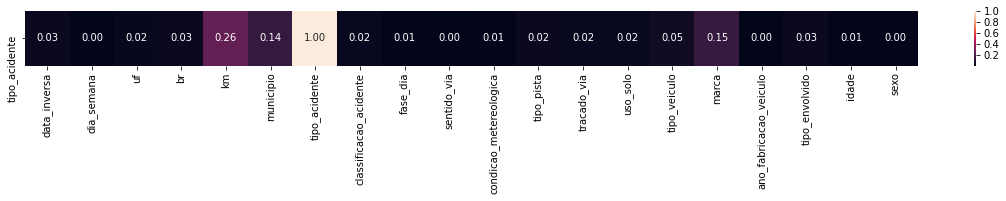

In [42]:
data = dataSourceCsv
theilu = pd.DataFrame(index=['tipo_acidente'],columns=data.columns)
columns = data.columns

for j in range(0,len(columns)):
    u = theil_u(data['tipo_acidente'].tolist(),data[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

Para o protótipo, escolhemos o DataSet de *Agrupados por pessoa - Todas as causas e tipos de acidentes em 2019*, disponível no link https://portal.prf.gov.br/dados-abertos-acidentes.

Nossa intenção é ao usuário informar os dados necessários, o sistema predizer qual possível acidente ele sofreria.

Fizemos toda a analise dos dados no python e encontramos uma grande dificuldade na parte de correlação entre os dados, já que os dados eram praticamente qualitativos. Encontramos ao formula Theil's U.

Utilizando da formula U(x|y), esse coeficiente fornece um valor no intervalo de [0,1], onde 0 significa que o recurso y não fornece informações sobre o recurso x e 1 que fornece informações. E com isso, conseguimos identificar a correlação de alguns dados, o que mesmo assim, eram bem baixos.

Após essas analises, partimos para a treino, que nos resultou em outros ‘problemas’, onde precisamos de uma classificação múltipla, além de ter que transformar os testos em ‘matrix’.

Com isso, aplicamos o one-hot-encode nos dados e seguimos para a criação do modelo, o qual não conseguimos uma acurácia maior que 40%. 

Os dados mais importantes para encontrar o tipo de acidente eram dados ‘futuros’, como se ocorreu óbito e ferido por exemplo, dados dos quais não poderíamos utilizar, já que não fazia sentido perguntar para o usuário se no acidente que ele nem sabe qual seria, se ocorreu óbito ou não por exemplo.

Na variável ‘Causa_acidente’, encontramos uma forma de entender como a pessoa se comporta ao volante, assim com se ela efetua as devidas manutenções no veículo, e essa nos trazia uma grande ajuda na predição do tipo de acidente que a pessoa poderia sofrer.

Criamos grupos, limpamos mais dados, entre outros e a acuraria não mudou tanto, ficando por volta de 40%. 

Percebemos também que o DataSet tinha um desbalanceamento muito grande de acidentes por municípios, o que poderia ser um dos motivos da nossa acuraria estar tão baixa. 

Fizemos mais testes e mesmo assim, nossa acurácia não mudou muito.

Seguimos com o projeto para a publicação, mesmo com uma acurácia mais baixa. 

Para implantar o modelo, optamos para fazer isso na linguagem C# utilizando o **[ML.net](https://dotnet.microsoft.com/apps/machinelearning-ai/ml-dotnet)**. Como a equipe está mais acostuma a programar em C# e a parte de analise estava pronta, decidimos deixar a criação do modelo no C#. Com isso, tivemos o seguinte fluxo nesse trabalho.
•	Analise e tratamento de dados no Python;<br>
•	Geração de DataSet tratado pelo Python;<br>
•	Carga do DataSet tratado no C#;<br>
•	Criação do modelo de predição no C#;<br>
•	Carregamento do modelo de predição no C#;<br>
•	Criação da API no C#;<br>
•	Criação da tela de UI no C#.;<br>

Fizemos essa mescla de tecnologias e conseguimos trabalhar muito bem, aproveitando o que cada uma tinha de melhor e no que estávamos mais adaptados na equipe. Infelizmente o C# não tem uma forma tão amigável de apresentar os dados como no Python e Jupyter, até encontramos uma forma de rodar o C# no Jupyter, porém, a parte de gráficos no C# ainda é fraca comparada ao Python.


Acho que é isso pessoal

Obrigado a todos e ao professor.